# Variational Quantum Eigensolver

We provide a Perceval implementation  of original photonic Variational Quantum Eigensolver (VQE) from  Peruzzo, A. et al. in [1].

This notebook provides computations of ground-state molecular energies for the Hamiltonian given by the following papers:

$\bullet$ A variational eigenvalue solver on a photonic quantum processor [1].
 
$\bullet$ Scalable Quantum Simulation of Molecular Energies [2] .
 
$\bullet$ Computation of Molecular Spectra on a Quantum Processor with an Error-Resilient Algorithm [3]

Importing the necessary packages for the computations:

In [17]:
from tqdm.auto import tqdm

import perceval as pcvl

import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
simulator = pcvl.Simulator(pcvl.NaiveBackend())

## Implementation in Perceval

Here we reproduce on Perceval the 2-qubit circuit used in  [1] for VQE.

We use path encoded qubits.

Modes 0 and 5 are auxiliary. 1$^\text{st}$ qubit is path encoded in modes 1 and 2. 2$^\text{and}$ qubit in modes 3 and 4.

The circuit is :


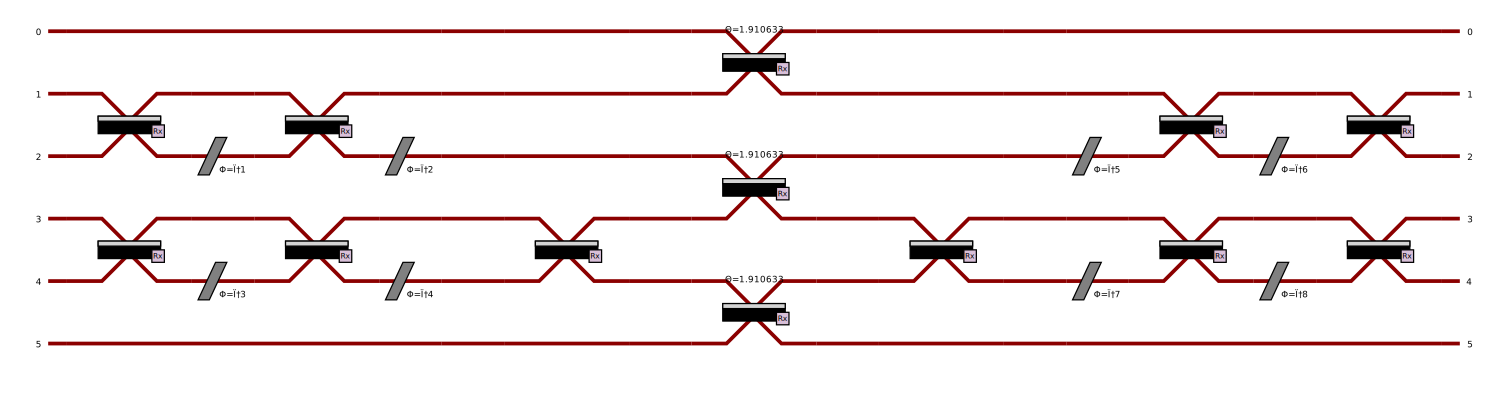

In [37]:
#List of the parameters Ï†1,Ï†2,...,Ï†8
List_Parameters=[]

# VQE is a 6 optical mode circuit
VQE=pcvl.Circuit(6)

VQE.add((1,2), pcvl.BS())
VQE.add((3,4), pcvl.BS())
List_Parameters.append(pcvl.Parameter("Ï†1"))
VQE.add((2,),pcvl.PS(phi=List_Parameters[-1]))
List_Parameters.append(pcvl.Parameter("Ï†3"))
VQE.add((4,),pcvl.PS(phi=List_Parameters[-1]))
VQE.add((1,2), pcvl.BS())
VQE.add((3,4), pcvl.BS())
List_Parameters.append(pcvl.Parameter("Ï†2"))
VQE.add((2,),pcvl.PS(phi=List_Parameters[-1]))
List_Parameters.append(pcvl.Parameter("Ï†4"))
VQE.add((4,),pcvl.PS(phi=List_Parameters[-1]))


# CNOT ( Post-selected with a success probability of 1/9) 
VQE.add([0,1,2,3,4,5], pcvl.PERM([0,1,2,3,4,5]))#Identity PERM (permutation) for the purpose of drawing a nice circuit
VQE.add((3,4), pcvl.BS())
VQE.add([0,1,2,3,4,5], pcvl.PERM([0,1,2,3,4,5]))#Identity PERM (permutation) for the same purpose
VQE.add((0,1), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
VQE.add((2,3), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
VQE.add((4,5), pcvl.BS(pcvl.BS.r_to_theta(1/3)))
VQE.add([0,1,2,3,4,5], pcvl.PERM([0,1,2,3,4,5]))#Identity PERM (permutation) for the same purpose
VQE.add((3,4), pcvl.BS())
VQE.add([0,1,2,3,4,5], pcvl.PERM([0,1,2,3,4,5]))#Identity PERM (permutation) for the same purpose

List_Parameters.append(pcvl.Parameter("Ï†5"))
VQE.add((2,),pcvl.PS(phi=List_Parameters[-1]))
List_Parameters.append(pcvl.Parameter("Ï†7"))
VQE.add((4,),pcvl.PS(phi=List_Parameters[-1]))
VQE.add((1,2), pcvl.BS())
VQE.add((3,4), pcvl.BS())
List_Parameters.append(pcvl.Parameter("Ï†6"))
VQE.add((2,),pcvl.PS(phi=List_Parameters[-1]))
List_Parameters.append(pcvl.Parameter("Ï†8"))
VQE.add((4,),pcvl.PS(phi=List_Parameters[-1]))
VQE.add((1,2), pcvl.BS())
VQE.add((3,4), pcvl.BS())

# Mode 0 and 5 are auxiliary.
#1st qubit is path encoded in modes 1 & 2
#2nd qubit in 3 & 4

print("The circuit is :")
pcvl.pdisplay(VQE)

## Logical input and output states

Logical states are path encoded on the Fock States.

In [19]:
#Input states of the photonic circuit
input_states = {
    pcvl.BasicState([0,1,0,1,0,0]):"|00>"}

#Outputs in the computational basis
output_states = {
    pcvl.BasicState([0,1,0,1,0,0]):"|00>",
    pcvl.BasicState([0,1,0,0,1,0]):"|01>",
    pcvl.BasicState([0,0,1,1,0,0]):"|10>",
    pcvl.BasicState([0,0,1,0,1,0]):"|11>"}

## Loss function for the variational algorithm

For a given state $|\psi \rangle$ the Rayleigh-Ritz quotient is given by:
$$ \frac{\langle \psi | \mathcal{H} | \psi \rangle}{\langle \psi |\psi \rangle},$$
This is computed in Perceval by explicitly computing $|\psi \rangle$ ( which is the output of the simulated photonic circuit).
Determining the smallest/ground state eigenvalue is done through a variational approach with Rayleigh-Ritz quotient as the loss function.

Using a classical optimisation algorithm, and the simulations given by Perceval we find the eigenvector which minimises the Rayleigh-Ritz quotient together with its associated eigenvalue ( the ground state eigenvalue), which reprensents the solution of the VQE.




In [20]:

def minimize_loss(lp=None): 
    # Updating the parameters on the chip
    for idx, p in enumerate(lp):                    
        List_Parameters[idx].set_value(p)
    
    #Simulation, Quantum processing part of the VQE
    simulator.set_circuit(VQE)
    
    # Collecting the output state of the circuit    
    psi = [] 
    for input_state in input_states:
        for output_state in output_states: #|00>,|01>,|10>,|11>
            psi.append(simulator.prob_amplitude(input_state,output_state))
            
        #Evaluating the mean value of the Hamiltonian.  # The Hamiltonians H is defined in the following block
    psi_prime=np.dot(H[R][1],psi)
    loss = np.real(sum(sum(np.conjugate(psi)*np.array(psi_prime[0]))))/(sum([i*np.conjugate(i) for i in psi]))
    loss=np.real(loss)
    
    tq.set_description('%g / %g  loss function=%g' % (R, len(H), loss))
    return(loss)


## Hamiltonians for VQE

In this section we define the 3 Hamiltonians given by the 3  papers [1-3]

Perceval can compute the state vector, which is the output of the photonic quantum circuit, explicitly.
This eliminates the need for using algorithms to estimate the expectation value.

A Hamiltonian can be written as :
$$\mathcal{H}= \sum_{\sigma }h_{\sigma}\sigma$$
where $h_{\sigma} \in \mathbb{R}$ and $\sigma$ are pauli operators.

### Hamiltonian nÂ°1 [\[1\]](https://www.nature.com/articles/ncomms5213)

Hamiltonian coefficients on the [supplementary paper](https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5213/MediaObjects/41467_2014_BFncomms5213_MOESM1050_ESM.pdf):


In [ ]:
Hamiltonian_elem = np.array([[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],    #00
                             [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],    #II
                             [[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]],    #IX
                             [[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]],  #IZ
                             [[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]],    #XI
                             [[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]],    #XX
                             [[0,0,1,0],[0,0,0,-1],[1,0,0,0],[0,-1,0,0]],  #XZ
                             [[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]],  #ZI
                             [[0,1,0,0],[1,0,0,0],[0,0,0,-1],[0,0,-1,0]],  #ZX
                             [[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]]) #ZZ

Hamiltonian_coef = np.matrix(
# [R, II, IX, IZ, XI, XX, XZ, ZI, ZX, ZZ]   
[[0.05,33.9557,-0.1515,-2.4784,-0.1515,0.1412,0.1515,-2.4784,0.1515,0.2746],
[0.1,13.3605,-0.1626,-2.4368,-0.1626,0.2097,0.1626,-2.4368,0.1626,0.2081],
[0.15,6.8232,-0.1537,-2.3801,-0.1537,0.2680,0.1537,-2.3801,0.1537,0.1512],
[0.2,3.6330,-0.1405,-2.2899,-0.1405,0.3027,0.1405,-2.2899,0.1405,0.1176],
[0.25,1.7012,-0.1324,-2.1683,-0.1324,0.3211,0.1324,-2.1683,0.1324,0.1010],
[0.3,0.3821,-0.1306,-2.0305,-0.1306,0.3303,0.1306,-2.0305,0.1306,0.0943],
[0.35,-0.5810,-0.1335,-1.8905,-0.1335,0.3344,0.1335,-1.8905,0.1335,0.0936],
[0.4,-1.3119,-0.1396,-1.7568,-0.1396,0.3352,0.1396,-1.7568,0.1396,0.0969],
[0.45,-1.8796,-0.1477,-1.6339,-0.1477,0.3339,0.1477,-1.6339,0.1477,0.1030],
[0.5,-2.3275,-0.1570,-1.5236,-0.1570,0.3309,0.1570,-1.5236,0.1570,0.1115],
[0.55,-2.6844,-0.1669,-1.4264,-0.1669,0.3264,0.1669,-1.4264,0.1669,0.1218],
[0.6,-2.9708,-0.1770,-1.3418,-0.1770,0.3206,0.1770,-1.3418,0.1770,0.1339],
[0.65,-3.2020,-0.1871,-1.2691,-0.1871,0.3135,0.1871,-1.2691,0.1871,0.1475],
[0.7,-3.3893,-0.1968,-1.2073,-0.1968,0.3052,0.1968,-1.2073,0.1968,0.1626],
[0.75,-3.5417,-0.2060,-1.1552,-0.2060,0.2958,0.2060,-1.1552,0.2060,0.1791],
[0.8,-3.6660,-0.2145,-1.1117,-0.2145,0.2853,0.2145,-1.1117,0.2145,0.1968],
[0.85,-3.7675,-0.2222,-1.0758,-0.2222,0.2738,0.2222,-1.0758,0.2222,0.2157],
[0.9,-3.8505,-0.2288,-1.0466,-0.2288,0.2613,0.2288,-1.0466,0.2288,0.2356],
[0.95,-3.9183,-0.2343,-1.0233,-0.2343,0.2481,0.2343,-1.0233,0.2343,0.2564],
[1,-3.9734,-0.2385,-1.0052,-0.2385,0.2343,0.2385,-1.0052,0.2385,0.2779],
[1.05,-4.0180,-0.2414,-0.9916,-0.2414,0.2199,0.2414,-0.9916,0.2414,0.3000],
[1.1,-4.0539,-0.2430,-0.9820,-0.2430,0.2053,0.2430,-0.9820,0.2430,0.3225],
[1.15,-4.0825,-0.2431,-0.9758,-0.2431,0.1904,0.2431,-0.9758,0.2431,0.3451],
[1.2,-4.1050,-0.2418,-0.9725,-0.2418,0.1756,0.2418,-0.9725,0.2418,0.3678],
[1.25,-4.1224,-0.2392,-0.9716,-0.2392,0.1610,0.2392,-0.9716,0.2392,0.3902],
[1.3,-4.1356,-0.2353,-0.9728,-0.2353,0.1466,0.2353,-0.9728,0.2353,0.4123],
[1.35,-4.1454,-0.2301,-0.9757,-0.2301,0.1327,0.2301,-0.9757,0.2301,0.4339],
[1.4,-4.1523,-0.2239,-0.9798,-0.2239,0.1194,0.2239,-0.9798,0.2239,0.4549],
[1.45,-4.1568,-0.2167,-0.9850,-0.2167,0.1068,0.2167,-0.9850,0.2167,0.4751],
[1.5,-4.1594,-0.2086,-0.9910,-0.2086,0.0948,0.2086,-0.9910,0.2086,0.4945],
[1.55,-4.1605,-0.1998,-0.9975,-0.1998,0.0837,0.1998,-0.9975,0.1998,0.5129],
[1.6,-4.1602,-0.1905,-1.0045,-0.1905,0.0734,0.1905,-1.0045,0.1905,0.5304],
[1.65,-4.1589,-0.1807,-1.0116,-0.1807,0.0640,0.1807,-1.0116,0.1807,0.5468],
[1.7,-4.1568,-0.1707,-1.0189,-0.1707,0.0555,0.1707,-1.0189,0.1707,0.5622],
[1.75,-4.1540,-0.1605,-1.0262,-0.1605,0.0479,0.1605,-1.0262,0.1605,0.5766],
[1.8,-4.1508,-0.1503,-1.0334,-0.1503,0.0410,0.1503,-1.0334,0.1503,0.5899],
[1.85,-4.1471,-0.1403,-1.0404,-0.1403,0.0350,0.1403,-1.0404,0.1403,0.6023],
[1.9,-4.1431,-0.1305,-1.0473,-0.1305,0.0297,0.1305,-1.0473,0.1305,0.6138],
[1.95,-4.1390,-0.1210,-1.0540,-0.1210,0.0251,0.1210,-1.0540,0.1210,0.6244],
[2,-4.1347,-0.1119,-1.0605,-0.1119,0.0212,0.1119,-1.0605,0.1119,0.6342],
[2.05,-4.1303,-0.1031,-1.0667,-0.1031,0.0178,0.1031,-1.0667,0.1031,0.6432],
[2.1,-4.1258,-0.0949,-1.0727,-0.0949,0.0148,0.0949,-1.0727,0.0949,0.6516],
[2.15,-4.1214,-0.0871,-1.0785,-0.0871,0.0124,0.0871,-1.0785,0.0871,0.6594],
[2.2,-4.1169,-0.0797,-1.0840,-0.0797,0.0103,0.0797,-1.0840,0.0797,0.6666],
[2.25,-4.1125,-0.0729,-1.0893,-0.0729,0.0085,0.0729,-1.0893,0.0729,0.6733],
[2.3,-4.1082,-0.0665,-1.0944,-0.0665,0.0070,0.0665,-1.0944,0.0665,0.6796],
[2.35,-4.1040,-0.0606,-1.0993,-0.0606,0.0058,0.0606,-1.0993,0.0606,0.6854],
[2.4,-4.0998,-0.0551,-1.1040,-0.0551,0.0047,0.0551,-1.1040,0.0551,0.6909],
[2.45,-4.0957,-0.0500,-1.1085,-0.0500,0.0039,0.0500,-1.1085,0.0500,0.6961],
[2.5,-4.0918,-0.0454,-1.1128,-0.0454,0.0032,0.0454,-1.1128,0.0454,0.7010],
[2.55,-4.0879,-0.0411,-1.1170,-0.0411,0.0026,0.0411,-1.1170,0.0411,0.7056],
[2.6,-4.0841,-0.0371,-1.1210,-0.0371,0.0021,0.0371,-1.1210,0.0371,0.7099],
[2.65,-4.0805,-0.0335,-1.1248,-0.0335,0.0017,0.0335,-1.1248,0.0335,0.7141],
[2.7,-4.0769,-0.0303,-1.1285,-0.0303,0.0014,0.0303,-1.1285,0.0303,0.7181],
[2.75,-4.0735,-0.0273,-1.1321,-0.0273,0.0011,0.0273,-1.1321,0.0273,0.7218],
[2.8,-4.0701,-0.0245,-1.1356,-0.0245,0.0009,0.0245,-1.1356,0.0245,0.7254],
[2.85,-4.0669,-0.0221,-1.1389,-0.0221,0.0007,0.0221,-1.1389,0.0221,0.7289],
[2.9,-4.0638,-0.0198,-1.1421,-0.0198,0.0006,0.0198,-1.1421,0.0198,0.7322],
[2.95,-4.0607,-0.0178,-1.1452,-0.0178,0.0005,0.0178,-1.1452,0.0178,0.7354],
[3,-4.0578,-0.0159,-1.1482,-0.0159,0.0004,0.0159,-1.1482,0.0159,0.7385],
[3.05,-4.0549,-0.0142,-1.1511,-0.0142,0.0003,0.0142,-1.1511,0.0142,0.7414],
[3.1,-4.0521,-0.0127,-1.1539,-0.0127,0.0002,0.0127,-1.1539,0.0127,0.7443],
[3.15,-4.0494,-0.0114,-1.1566,-0.0114,0.0002,0.0114,-1.1566,0.0114,0.7470],
[3.2,-4.0468,-0.0101,-1.1592,-0.0101,0.0001,0.0101,-1.1592,0.0101,0.7497],
[3.25,-4.0443,-0.0090,-1.1618,-0.0090,0.0001,0.0090,-1.1618,0.0090,0.7522],
[3.3,-4.0418,-0.0081,-1.1643,-0.0081,0.0001,0.0081,-1.1643,0.0081,0.7547],
[3.35,-4.0394,-0.0072,-1.1666,-0.0072,0.0001,0.0072,-1.1666,0.0072,0.7571],
[3.4,-4.0371,-0.0064,-1.1690,-0.0064,0.0001,0.0064,-1.1690,0.0064,0.7595],
[3.45,-4.0349,-0.0056,-1.1712,-0.0056,0.0000,0.0056,-1.1712,0.0056,0.7617],
[3.5,-4.0327,-0.0050,-1.1734,-0.0050,0.0000,0.0050,-1.1734,0.0050,0.7639],
[3.55,-4.0306,-0.0044,-1.1756,-0.0044,0.0000,0.0044,-1.1756,0.0044,0.7661],
[3.6,-4.0285,-0.0039,-1.1776,-0.0039,0.0000,0.0039,-1.1776,0.0039,0.7681],
[3.65,-4.0265,-0.0035,-1.1796,-0.0035,0.0000,0.0035,-1.1796,0.0035,0.7702],
[3.7,-4.0245,-0.0030,-1.1816,-0.0030,0.0000,0.0030,-1.1816,0.0030,0.7721],
[3.75,-4.0226,-0.0027,-1.1835,-0.0027,0.0000,0.0027,-1.1835,0.0027,0.7740],
[3.8,-4.0208,-0.0024,-1.1854,-0.0024,0.0000,0.0024,-1.1854,0.0024,0.7759],
[3.85,-4.0190,-0.0021,-1.1872,-0.0021,0.0000,0.0021,-1.1872,0.0021,0.7777],
[3.9,-4.0172,-0.0018,-1.1889,-0.0018,0.0000,0.0018,-1.1889,0.0018,0.7795],
[3.95,-4.0155,-0.0016,-1.1906,-0.0016,0.0000,0.0016,-1.1906,0.0016,0.7812]]
)

# Building the Hamiltonian H[0] = Radius, H[1] = H(Radius)
H1 = []
(n,m) = Hamiltonian_coef.shape
for i in range(n):  # i = Radius
    h_0 = 1.0 * np.matrix(Hamiltonian_elem[0])
    for j in range(1, m):
        h_0 += Hamiltonian_coef[i,j] * np.matrix(Hamiltonian_elem[j])
    H1.append([Hamiltonian_coef[i,0], h_0])

### Hamiltonian nÂ°2 [\[2\]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58)


In [22]:
Hamiltonian_elem = np.array([[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],       #00
                             [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],       #II
                             [[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]],     #ZI
                             [[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]],     #IZ
                             [[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]],     #ZZ
                             [[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]],       #XX
                             [[0,0,0,-1],[0,0,1,0],[0,1,0,0],[-1,0,0,0]]])    #YY
                             

Hamiltonian_coef = np.matrix(
# [R, II, ZI, IZ, ZZ, XX, YY]   
[[0.20,2.8489,0.5678,-1.4508,0.6799,0.0791,0.0791],
[0.25,2.1868,0.5449,-1.2870,0.6719,0.0798,0.0798],
[0.30,1.7252,0.5215,-1.1458,0.6631,0.0806,0.0806],
[0.35,1.3827,0.4982,-1.0226,0.6537,0.0815,0.0815],
[0.40,1.1182,0.4754,-0.9145,0.6438,0.0825,0.0825],
[0.45,0.9083,0.4534,-0.8194,0.6336,0.0835,0.0835],
[0.50,0.7381,0.4325,-0.7355,0.6233,0.0846,0.0846],
[0.55,0.5979,0.4125,-0.6612,0.6129,0.0858,0.0858],
[0.60,0.4808,0.3937,-0.5950,0.6025,0.0870,0.0870],
[0.65,0.3819,0.3760,-0.5358,0.5921,0.0883,0.0883],
[0.70,0.2976,0.3593,-0.4826,0.5818,0.0896,0.0896],
[0.75,0.2252,0.3435,-0.4347,0.5716,0.0910,0.0910],
[0.80,0.1626,0.3288,-0.3915,0.5616,0.0925,0.0925],
[0.85,0.1083,0.3149,-0.3523,0.5518,0.0939,0.0939],
[0.90,0.0609,0.3018,-0.3168,0.5421,0.0954,0.0954],
[0.95,0.0193,0.2895,-0.2845,0.5327,0.0970,0.0970],
[1.00,-0.0172,0.2779,-0.2550,0.5235,0.0986,0.0986],
[1.05,-0.0493,0.2669,-0.2282,0.5146,0.1002,0.1002],
[1.10,-0.0778,0.2565,-0.2036,0.5059,0.1018,0.1018],
[1.15,-0.1029,0.2467,-0.1810,0.4974,0.1034,0.1034],
[1.20,-0.1253,0.2374,-0.1603,0.4892,0.1050,0.1050],
[1.25,-0.1452,0.2286,-0.1413,0.4812,0.1067,0.1067],
[1.30,-0.1629,0.2203,-0.1238,0.4735,0.1083,0.1083],
[1.35,-0.1786,0.2123,-0.1077,0.4660,0.1100,0.1100],
[1.40,-0.1927,0.2048,-0.0929,0.4588,0.1116,0.1116],
[1.45,-0.2053,0.1976,-0.0792,0.4518,0.1133,0.1133],
[1.50,-0.2165,0.1908,-0.0666,0.4451,0.1149,0.1149],
[1.55,-0.2265,0.1843,-0.0549,0.4386,0.1165,0.1165],
[1.60,-0.2355,0.1782,-0.0442,0.4323,0.1181,0.1181],
[1.65,-0.2436,0.1723,-0.0342,0.4262,0.1196,0.1196],
[1.70,-0.2508,0.1667,-0.0251,0.4204,0.1211,0.1211],
[1.75,-0.2573,0.1615,-0.0166,0.4148,0.1226,0.1226],
[1.80,-0.2632,0.1565,-0.0088,0.4094,0.1241,0.1241],
[1.85,-0.2684,0.1517,-0.0015,0.4042,0.1256,0.1256],
[1.90,-0.2731,0.1472,0.0052,0.3992,0.1270,0.1270],
[1.95,-0.2774,0.1430,0.0114,0.3944,0.1284,0.1284],
[2.00,-0.2812,0.1390,0.0171,0.3898,0.1297,0.1297],
[2.05,-0.2847,0.1352,0.0223,0.3853,0.1310,0.1310],
[2.10,-0.2879,0.1316,0.0272,0.3811,0.1323,0.1323],
[2.15,-0.2908,0.1282,0.0317,0.3769,0.1335,0.1335],
[2.20,-0.2934,0.1251,0.0359,0.3730,0.1347,0.1347],
[2.25,-0.2958,0.1221,0.0397,0.3692,0.1359,0.1359],
[2.30,-0.2980,0.1193,0.0432,0.3655,0.1370,0.1370],
[2.35,-0.3000,0.1167,0.0465,0.3620,0.1381,0.1381],
[2.40,-0.3018,0.1142,0.0495,0.3586,0.1392,0.1392],
[2.45,-0.3035,0.1119,0.0523,0.3553,0.1402,0.1402],
[2.50,-0.3051,0.1098,0.0549,0.3521,0.1412,0.1412],
[2.55,-0.3066,0.1078,0.0572,0.3491,0.1422,0.1422],
[2.60,-0.3079,0.1059,0.0594,0.3461,0.1432,0.1432],
[2.65,-0.3092,0.1042,0.0614,0.3433,0.1441,0.1441],
[2.70,-0.3104,0.1026,0.0632,0.3406,0.1450,0.1450],
[2.75,-0.3115,0.1011,0.0649,0.3379,0.1458,0.1458],
[2.80,-0.3125,0.0997,0.0665,0.3354,0.1467,0.1467],
[2.85,-0.3135,0.0984,0.0679,0.3329,0.1475,0.1475]]

)


# Building the Hamiltonian H[0] = Radius, H[1] = H(Radius)
H2 = []
(n,m) = Hamiltonian_coef.shape
for i in range(n):  # i = Radius
    h_0 = 1.0 * np.matrix(Hamiltonian_elem[0])
    for j in range(1, m):
        h_0 += Hamiltonian_coef[i,j]*np.matrix(Hamiltonian_elem[j])
    H2.append([Hamiltonian_coef[i,0], h_0])

### Hamiltonian nÂ°3 [\[3\]](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.011021)

Hamiltonian coefficients on the [supplementary material](https://journals.aps.org/prx/supplemental/10.1103/PhysRevX.8.011021/Supplementary.pdf).

In [23]:
Hamiltonian_elem = np.array([[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]],      #00
                             [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],      #II
                             [[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]],    #ZI
                             [[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]],      #XX
                             [[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]],    #IZ
                             [[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]])   #ZZ

                             
Hamiltonian_coef = np.matrix(
# [R, II, ZI, XX, IZ, ZZ]
[[0.05, 1.00777E+01 ,-1.05533E+00 ,1.55708*10**(-1) ,-1.05533E+00 ,1.39333*10**(-2)],
[0.10, 4.75665E+00 ,-1.02731E+00 ,1.56170*10**(-1) ,-1.02731E+00 ,1.38667*10**(-2)],
[0.15, 2.94817E+00 ,-9.84234*10**(-1) ,1.56930*10**(-1) ,-9.84234*10**(-1) ,1.37610*10**(-2)],
[0.20, 2.01153E+00 ,-9.30489*10**(-1) ,1.57973*10**(-1) ,-9.30489*10**(-1) ,1.36238*10**(-2)],
[0.25, 1.42283E+00 ,-8.70646*10**(-1) ,1.59277*10**(-1) ,-8.70646*10**(-1) ,1.34635*10**(-2)],
[0.30, 1.01018E+00 ,-8.08649*10**(-1) ,1.60818*10**(-1) ,-8.08649*10**(-1) ,1.32880*10**(-2)],
[0.35, 7.01273*10**(-1) ,-7.47416*10**(-1) ,1.62573*10**(-1) ,-7.47416*10**(-1) ,1.31036*10**(-2)],
[0.40, 4.60364*10**(-1) ,-6.88819*10**(-1) ,1.64515*10**(-1) ,-6.88819*10**(-1) ,1.29140*10**(-2)],
[0.45, 2.67547*10**(-1) ,-6.33890*10**(-1) ,1.66621*10**(-1) ,-6.33890*10**(-1) ,1.27192*10**(-2)],
[0.50, 1.10647*10**(-1) ,-5.83080*10**(-1) ,1.68870*10**(-1) ,-5.83080*10**(-1) ,1.25165*10**(-2)],
[0.55, -1.83734*10**(-2), -5.36489*10**(-1), 1.71244*10**(-1), -5.36489*10**(-1), 1.23003*10**(-2)],
[0.65, -2.13932*10**(-1), -4.55433*10**(-1), 1.76318*10**(-1), -4.55433*10**(-1), 1.18019*10**(-2)],
[0.75, -3.49833*10**(-1), -3.88748*10**(-1), 1.81771*10**(-1), -3.88748*10**(-1), 1.11772*10**(-2)],
[0.85, -4.45424*10**(-1), -3.33747*10**(-1), 1.87562*10**(-1), -3.33747*10**(-1), 1.04061*10**(-2)],
[0.95, -5.13548*10**(-1), -2.87796*10**(-1), 1.93650*10**(-1), -2.87796*10**(-1), 9.50345*10**(-3)],
[1.05, -5.62600*10**(-1), -2.48783*10**(-1), 1.99984*10**(-1), -2.48783*10**(-1), 8.50998*10**(-3)],
[1.15, -5.97973*10**(-1), -2.15234*10**(-1), 2.06495*10**(-1), -2.15234*10**(-1), 7.47722*10**(-3)],
[1.25, -6.23223*10**(-1), -1.86173*10**(-1), 2.13102*10**(-1), -1.86173*10**(-1), 6.45563*10**(-3)],
[1.35, -6.40837*10**(-1), -1.60926*10**(-1), 2.19727*10**(-1), -1.60926*10**(-1), 5.48623*10**(-3)],
[1.45, -6.52661*10**(-1), -1.38977*10**(-1), 2.26294*10**(-1), -1.38977*10**(-1), 4.59760*10**(-3)],
[1.55, -6.60117*10**(-1), -1.19894*10**(-1), 2.32740*10**(-1), -1.19894*10**(-1), 3.80558*10**(-3)],
[1.65, -6.64309*10**(-1), -1.03305*10**(-1), 2.39014*10**(-1), -1.03305*10**(-1), 3.11545*10**(-3)],
[1.75, -6.66092*10**(-1), -8.88906*10**(-2), 2.45075*10**(-1), -8.88906*10**(-2), 2.52480*10**(-3)],
[1.85, -6.66126*10**(-1), -7.63712*10**(-2), 2.50896*10**(-1), -7.63712*10**(-2), 2.02647*10**(-3)],
[1.95, -6.64916*10**(-1), -6.55065*10**(-2), 2.56458*10**(-1), -6.55065*10**(-2), 1.61100*10**(-3)],
[2.05, -6.62844*10**(-1), -5.60866*10**(-2), 2.61750*10**(-1), -5.60866*10**(-2), 1.26812*10**(-3)],
[2.15, -6.60199*10**(-1), -4.79275*10**(-2), 2.66768*10**(-1), -4.79275*10**(-2), 9.88000*10**(-4)],
[2.25, -6.57196*10**(-1), -4.08672*10**(-2), 2.71512*10**(-1), -4.08672*10**(-2), 7.61425*10**(-4)],
[2.35, -6.53992*10**(-1), -3.47636*10**(-2), 2.75986*10**(-1), -3.47636*10**(-2), 5.80225*10**(-4)],
[2.45, -6.50702*10**(-1), -2.94924*10**(-2), 2.80199*10**(-1), -2.94924*10**(-2), 4.36875*10**(-4)],
[2.55, -6.47408*10**(-1), -2.49459*10**(-2), 2.84160*10**(-1), -2.49459*10**(-2), 3.25025*10**(-4)],
[2.65, -6.44165*10**(-1), -2.10309*10**(-2), 2.87881*10**(-1), -2.10309*10**(-2), 2.38800*10**(-4)],
[2.75, -6.41011*10**(-1), -1.76672*10**(-2), 2.91376*10**(-1), -1.76672*10**(-2), 1.73300*10**(-4)],
[2.85, -6.37971*10**(-1), -1.47853*10**(-2), 2.94658*10**(-1), -1.47853*10**(-2), 1.24200*10**(-4)],
[2.95, -6.35058*10**(-1), -1.23246*10**(-2), 2.97741*10**(-1), -1.23246*10**(-2), 8.78750*10**(-5)],
[3.05, -6.32279*10**(-1), -1.02318*10**(-2), 3.00638*10**(-1), -1.02317*10**(-2), 6.14500*10**(-5)],
[3.15, -6.29635*10**(-1), -8.45958*10**(-3), 3.03362*10**(-1), -8.45958*10**(-3), 4.24250*10**(-5)],
[3.25, -6.27126*10**(-1), -6.96585*10**(-3), 3.05927*10**(-1), -6.96585*10**(-3), 2.89500*10**(-5)],
[3.35, -6.24746*10**(-1), -5.71280*10**(-3), 3.08344*10**(-1), -5.71280*10**(-3), 1.95500*10**(-5)],
[3.45, -6.22491*10**(-1), -4.66670*10**(-3), 3.10625*10**(-1), -4.66670*10**(-3), 1.30500*10**(-5)],
[3.55, -6.20353*10**(-1), -3.79743*10**(-3), 3.12780*10**(-1), -3.79743*10**(-3), 8.57500*10**(-6)],
[3.65, -6.18325*10**(-1), -3.07840*10**(-3), 3.14819*10**(-1), -3.07840*10**(-3), 5.60000*10**(-6)],
[3.75, -6.16401*10**(-1), -2.48625*10**(-3), 3.16750*10**(-1), -2.48625*10**(-3), 3.60000*10**(-6)],
[3.85, -6.14575*10**(-1), -2.00063*10**(-3), 3.18581*10**(-1), -2.00062*10**(-3), 2.27500*10**(-6)],
[3.95, -6.12839*10**(-1), -1.60393*10**(-3), 3.20320*10**(-1), -1.60392*10**(-3), 1.42500*10**(-6)]] )
     
# Building the Hamiltonian H[0]= Radius, H[1]=H(Radius)
H3 = []
(n,m) = Hamiltonian_coef.shape
for i in range(n):  # i = Radius
    h_0 = 1.0 * np.matrix(Hamiltonian_elem[0])
    for j in range(1,m):
        h_0 += Hamiltonian_coef[i,j]*np.matrix(Hamiltonian_elem[j])
    H3.append([Hamiltonian_coef[i,0], h_0])

## Varational quantum eigenvalue solver simulation

We use the Nelder-Mead minimisation algorithm [4] from the `scipy.optimize` package.



### Simulation nÂ°1 

In [24]:
tq = tqdm(desc='Minimizing...') #Displaying progress bar
radius1=[]
E1=[]
init_param=[]

H=H1

for R in range(len(H)):  # We try to find the ground state eigenvalue for each radius R
    radius1.append(H[R][0])
    if len(init_param) == 0:
            init_param = [2*np.pi*random.random() for _ in List_Parameters]
    else:
        for i in range(len(init_param)):
            init_param[i] = VQE.get_parameters()[i]._value
            
    # Finding the ground state eigen value for each H(R)
    result = minimize(minimize_loss, init_param, method='Nelder-Mead')
    
    E1.append(result.get('fun'))
    tq.set_description('Finished' )
    

Minimizing...: 0it [00:00, ?it/s]

#### Simulation 1: computing the theoretical eigenvalues of H

 We use the numpy linalg package.

In [25]:
E1_th = []
for h in H:
    l0 = np.linalg.eigvals(h[1])
    l0.sort()
    E1_th.append(min(l0))

#### Simulation 1: plotting the results

The minimum eigenvalues of H are plotted in orange.

The eigenvalues found with Perceval are the crosses

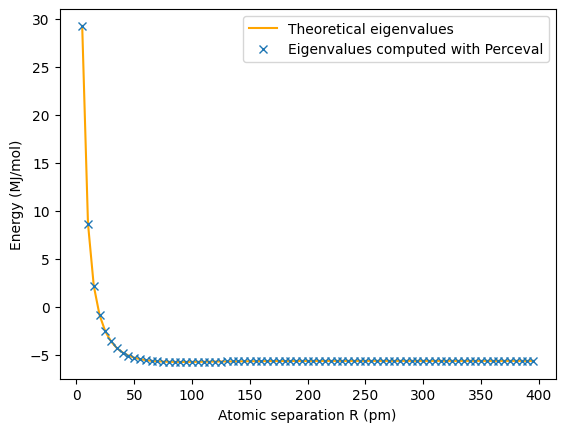

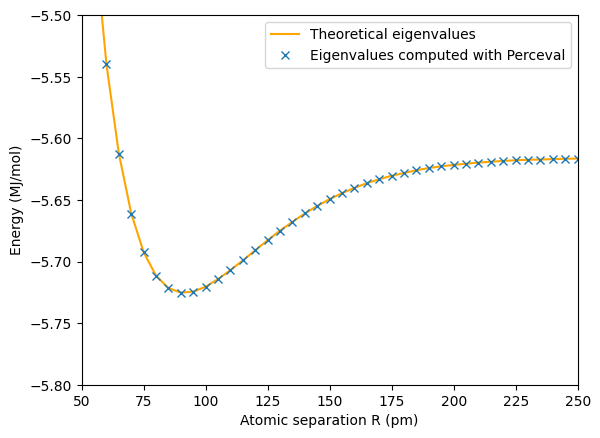

The minimum energy is E_g(0.9)=-5.725241528114039 MJ/mol and is attained for R_min =0.9 pm


In [26]:
plt.plot(100*np.array(radius1),E1_th,'orange')
plt.plot(100*np.array(radius1),E1,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')
plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])
plt.show()


plt.plot(100*np.array(radius1),E1_th,'orange')
plt.plot(100*np.array(radius1),E1,'x')
plt.axis([50,250,-5.8,-5.5])
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (pm)')

plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])

plt.show()

min_value=min(E1)
min_index = E1.index(min_value)
print('The minimum energy is E_g('+str(radius1[min_index])+')='+str(E1[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' pm')


### Simulation nÂ°2

In [27]:
tq = tqdm(desc='Minimizing...') #New progress bar
radius2=[]
E2=[]
init_param=[]

H=H2

for R in range(len(H)):            #We try to find the ground state eigenvalue for each radius R
    radius2.append(H[R][0])
    if len(init_param) == 0:           #
            init_param = [2*np.pi*random.random() for _ in List_Parameters]
    else:
        for i in range(len(init_param)):
            init_param[i] = VQE.get_parameters()[i]._value
            
    # Finding the ground state eigen value for each H(R)
    result = minimize(minimize_loss, init_param, method='Nelder-Mead')
    
    E2.append(result.get('fun'))
    tq.set_description('Finished')


Minimizing...: 0it [00:00, ?it/s]

#### Simulation 2: computing the theoretical eigenvalues of H

 We use the numpy linalg package.

In [28]:
E2_th=[]
for h in H:
    l0=np.linalg.eigvals(h[1])
    l0.sort()
    E2_th.append(min(l0))

#### Simulation 2: plotting the results

The minimum eigenvalues of H are plotted in orange.

The eigenvalues found with Perceval are the crosses

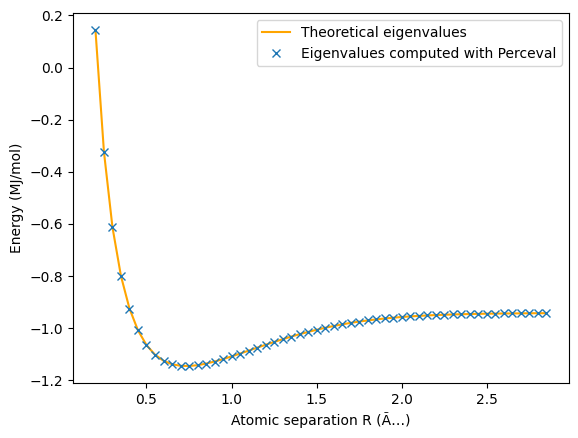

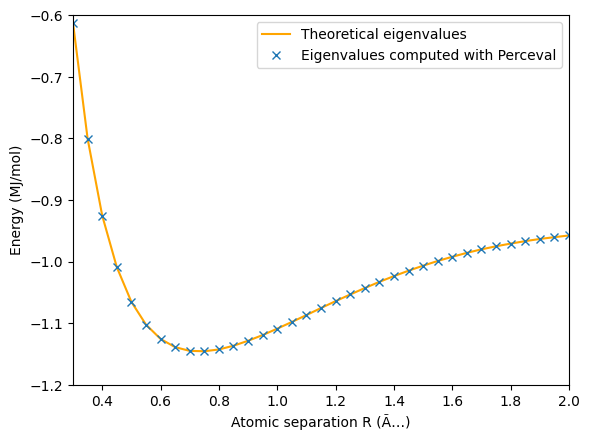

The minimum energy is E_g(0.75)=-1.1455991241055665 MJ/mol and is attained for R_min =0.6 Ã…


In [29]:
plt.plot(np.array(radius2),E2_th,'orange')
plt.plot(np.array(radius2),E2,'x')
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (Ã…)')
plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])
plt.show()


plt.plot(np.array(radius2),E2_th,'orange')
plt.plot(np.array(radius2),E2,'x')
plt.axis([0.3,2,-1.2,-0.6])
plt.ylabel('Energy (MJ/mol)')
plt.xlabel('Atomic separation R (Ã…)')
plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])
plt.show()

min_value=min(E2)
min_index = E2.index(min_value)
print('The minimum energy is E_g('+str(radius2[min_index])+')='+str(E2[min_index])+' MJ/mol and is attained for R_min ='+str(radius1[min_index])+' Ã…')


### Simulation nÂ°3

In [30]:
tq = tqdm(desc='Minimizing...') #New progress bar
radius3=[]
E3=[]
init_param=[]

H=H3

for R in range(len(H)):            #We try to find the ground state eigenvalue for each radius R
    radius3.append(H[R][0])
    if len(init_param) == 0:           #
            init_param = [2*np.pi*random.random() for _ in List_Parameters]
    else:
        for i in range(len(init_param)):
            init_param[i] = VQE.get_parameters()[i]._value
            
    # Finding the ground state eigen value for each H(R)
    result=minimize(minimize_loss, init_param, method='Nelder-Mead')
    
    E3.append(result.get('fun'))
    tq.set_description('Finished' )
    

Minimizing...: 0it [00:00, ?it/s]

#### Simulation 3: computing the theoretical eigenvalues of H

 We use the numpy linalg package.

In [31]:
E3_th=[]
for h in H:
    l0=np.linalg.eigvals(h[1])
    l0.sort()
    E3_th.append(min(l0))

#### Simulation 3: plotting the results

The minimum eigenvalue of H is plotted in orange. 

The eigenvalues found with Perceval are the crosses

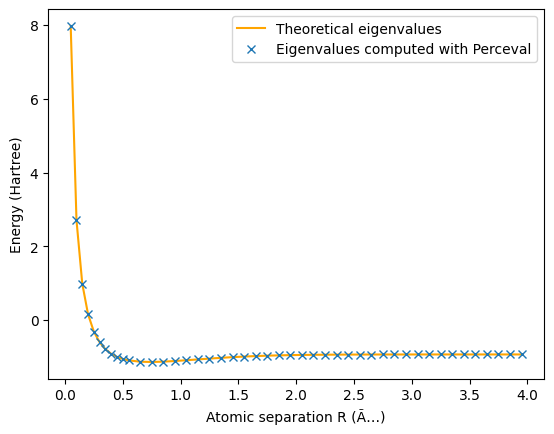

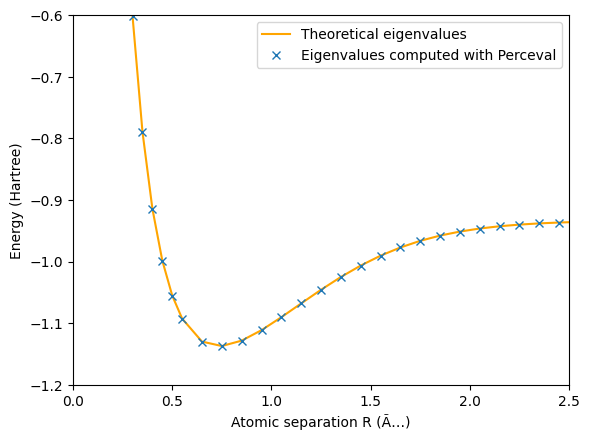

The minimum energy is E_g(0.75)=-1.1371172745492966 Hartree and is attained for R_min =0.75 Ã…


In [32]:
plt.plot(np.array(radius3),E3_th,'orange')
plt.plot(np.array(radius3),E3,'x')
plt.ylabel('Energy (Hartree)')
plt.xlabel('Atomic separation R (Ã…)')
plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])
plt.show()


plt.plot(np.array(radius3),E3_th,'orange')
plt.plot(np.array(radius3),E3,'x')
plt.axis([0,2.5,-1.2,-0.6])
plt.ylabel('Energy (Hartree)')
plt.xlabel('Atomic separation R (Ã…)')
plt.legend(['Theoretical eigenvalues', 'Eigenvalues computed with Perceval'])
plt.show()

min_value=min(E3)
min_index = E3.index(min_value)
print('The minimum energy is E_g('+str(radius3[min_index])+')='+str(E3[min_index])+' Hartree and is attained for R_min ='+str(radius3[min_index])+' Ã…')

## References

> [1] A. Peruzzo, J. McClean, P. Shadbolt, M.-H. Yung, X.-Q. Zhou, P. J. Love,A. Aspuru-Guzik, and J. L. Oâ€™Brien, â€œA variational eigenvalue solver on a photonicquantum processorâ€, [Nature Communications](https://www.nature.com/articles/ncomms5213) 5, 4213 (2014).

> [2] P.J.J. Oâ€™Malley et al., "Scalable Quantum Simulation of Molecular Energies", [Phys. Rev. X](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58) 6, 031007 (2016)

> [3] J.I. Colless, et al., "Computation of Molecular Spectra on a Quantum Processor with an Error-Resilient Algorithm", [Phys. Rev. X](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.011021) 8, 011021 (2018)

> [4] J. A. Nelder and R. Mead, â€œA simplex method for function minimizationâ€, [The computer journal](https://people.duke.edu/~hpgavin/cee201/Nelder+Mead-ComputerJournal-1965.pdf) 7, 308â€“313 (1965).